<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/raster_mosaic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 42.7MB/s 


In [ ]:
import os
import urllib
import urllib.parse
import requests

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepaths
outdir = r"content/"

# File locations
url_list = ["http://landsat-pds.s3.amazonaws.com/c1/L8/043/034/LC08_L1TP_043034_20170616_20170629_01_T1/LC08_L1TP_043034_20170616_20170629_01_T1_B4.TIF"]

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in url_list:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

In [9]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
%matplotlib inline

# File and folder paths
dirpath = "/content/content"
out_fp = os.path.join(dirpath, "Landsat_Mosaic.tif")

# Make a search criteria to select the DEM files
search_criteria = "L*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

/content/content/L*.tif


In [11]:
# glob function can be used to list files from a directory with specific criteria
lnd_fps = glob.glob(q)

# Files that were found:
lnd_fps

['/content/content/LC08_L1TP_042034_20170616_20170629_01_T1_B4.tif',
 '/content/content/LC08_L1TP_042034_20170616_20170629_01_T1_B4_2.tif']

In [13]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in lnd_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='/content/content/LC08_L1TP_042034_20170616_20170629_01_T1_B4.tif' mode='r'>,
 <open DatasetReader name='/content/content/LC08_L1TP_042034_20170616_20170629_01_T1_B4_2.tif' mode='r'>]

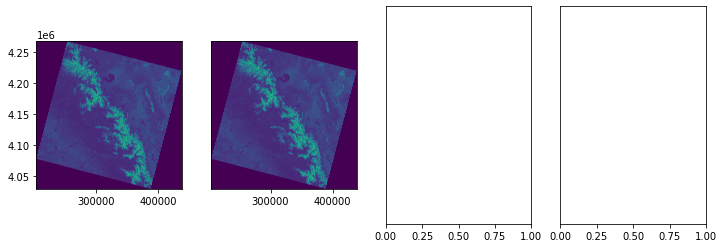

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
#show(src_files_to_mosaic[2], ax=ax3)
#show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

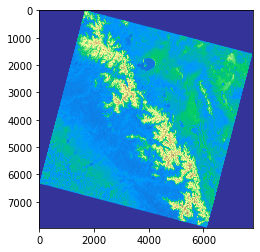

In [16]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap='terrain')

In [17]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )

In [18]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)